# SAAS dataset EDA

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter
import pandas as pd

In [2]:
url = 'https://ds.codeup.com/saas.csv'
df = pd.read_csv(url)
print('shape:', df.shape)
df.head()

shape: (790458, 5)


,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


Questions:

- Is `invoice_id` a unique identifier for a row?
- How many customers do we have? Is that number changing over time?
- What are the different subscription types? How many customers are on each?
- Is the distribution of subscription types changing over time?
- What does revenue over time look like?
- Can we calculate churn rate? Can we calculate our conversion rate?

In [3]:
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=13)
plt.style.use('bmh')

## Data Prep

In [4]:
# Lowercase column names
df.columns = [col.lower() for col in df]
# Properly parse the datetime field
df.month_invoiced = pd.to_datetime(df.month_invoiced)

I suspect subscription type and amount are integers, let's confirm and then convert to the right data types.

In [5]:
df.subscription_type.value_counts()

0.0    496410
1.0    178212
2.0     70706
3.0     26474
4.0     18656
Name: subscription_type, dtype: int64

In [6]:
df.subscription_type = df.subscription_type.astype(int)

In [7]:
df.amount.value_counts()

0.0     496410
5.0     178212
10.0     70706
15.0     26474
20.0     18656
Name: amount, dtype: int64

In [8]:
df.amount = df.amount.astype(int)

In [9]:
# a datetime index is probably a good idea
df = df.set_index('month_invoiced')

## Data Wrangling

Trying to get my head around what the data set means.

What's invoice id?

In [10]:
print('rows:', df.shape[0])
print('unique invoice ids:', df.invoice_id.nunique())

rows: 790458
unique invoice ids: 790458


Looks like invoice id does uniquely identify a row. We probably won't use this much.

Are subscription types and amounts related? Probably, but let's confirm

In [11]:
pd.crosstab(df.subscription_type, df.amount)

amount,0,5,10,15,20
subscription_type,,,,,
0,496410,0,0,0,0
1,0,178212,0,0,0
2,0,0,70706,0,0
3,0,0,0,26474,0
4,0,0,0,0,18656


Yes, it looks like there's only one combination of subscription type and amount. So, for example, if a cusomter is on subscription type 2, we know they pay $10 a month.

It also looks like we have 4 paid plans (subscription type 1-4) and a free tier (subscription type == 0).

How many unique customers are there?

In [12]:
df.customer_id.nunique()

29400

How many observations are there each month?

Text(0.5, 1.0, 'How many observations are there each month?')

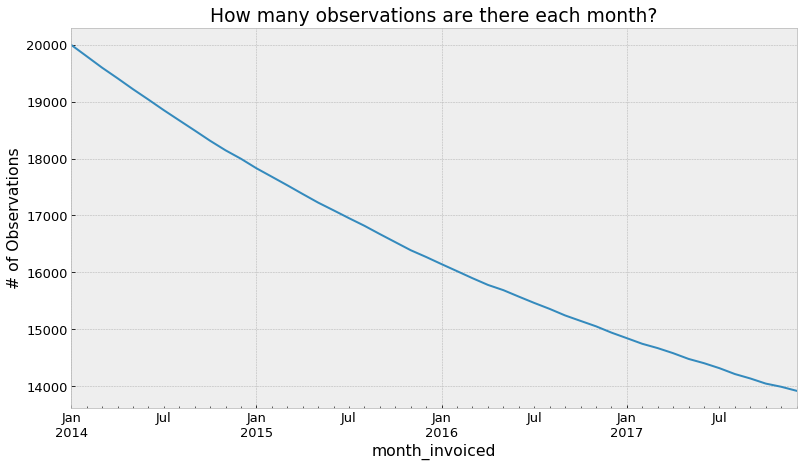

In [13]:
df.resample('M').size().plot()
plt.ylabel('# of Observations')
plt.title('How many observations are there each month?')

Interesting, it looks like there are less observations each month as time goes on. Does this mean we are losing customers?

## Visualize

Let's start by looking at monthly revenue over time.

[Text(0, 0.5, 'Revenue'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Revenue Over time')]

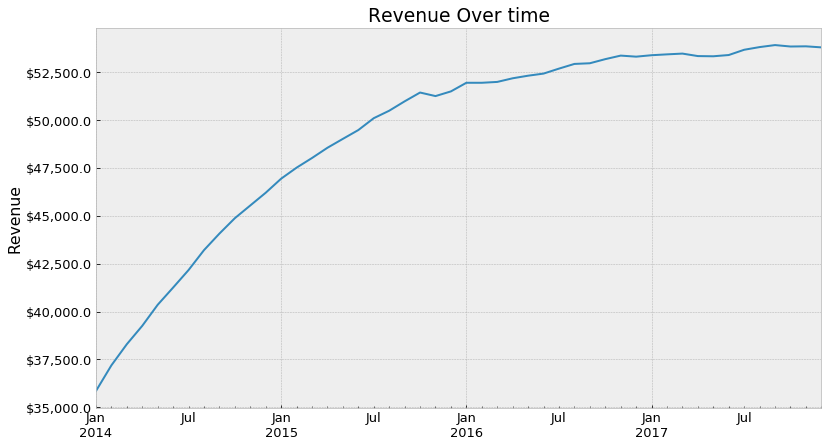

In [14]:
ax = df.resample('M').amount.sum().plot()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))
ax.set(title='Revenue Over time', ylabel='Revenue', xlabel='')

Looks like it is going up, but hitting a cap.

Maybe this is because we are losing customers? I might guess that while we are losing a total # of customers over time, the customers we do have are converting from the free plan to paid plans, or the customers on paid plans are upgrading.

Let's see if we can take a look at the subscription types over time.

[Text(0, 0.5, '# of Customers'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Distribution of Subscription Types')]

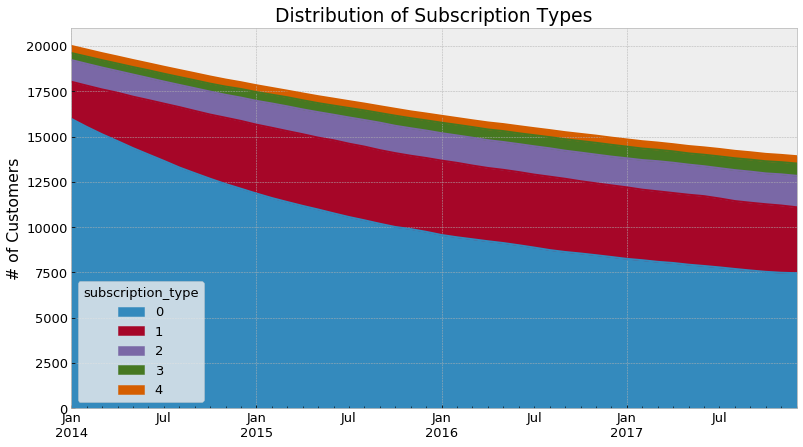

In [15]:
ax = df.groupby('subscription_type').resample('M').size().T.plot.area()
ax.set(title='Distribution of Subscription Types', xlabel='', ylabel='# of Customers')

Takeaways:

- The total number of customers is definitely going down over time
- Most of the customers are on the free tier
- It looks like percentage of customers on the free tier is going down over time

Next steps:

- Look at percentages instead of raw counts
- Look at free vs paid customers
- Filter out free tier customers, just look at paid customers

Next let's look at the same visualization above, but with percentages instead of count

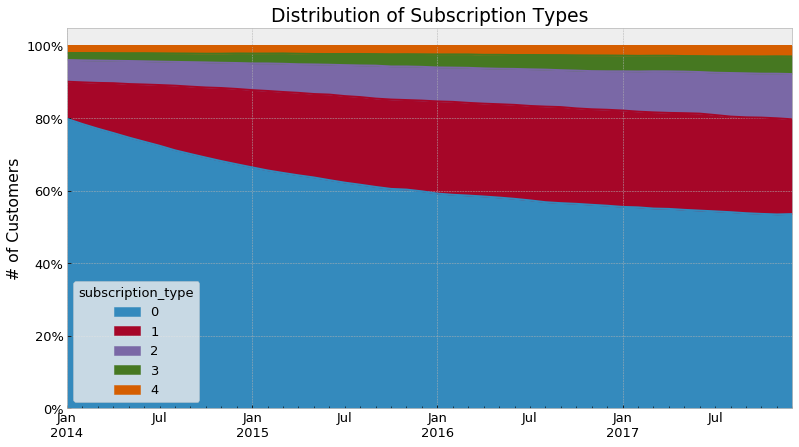

In [16]:
ax = (
    df.groupby("subscription_type")
    .resample("M")
    .size()
    .T.apply(lambda row: row / row.sum(), axis=1)
    .plot.area()
)
ax.set(title='Distribution of Subscription Types', xlabel='', ylabel='# of Customers')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))

Looks like our overall % of customers on paid plans is going up over time.

Let's now explore free vs paid customers.

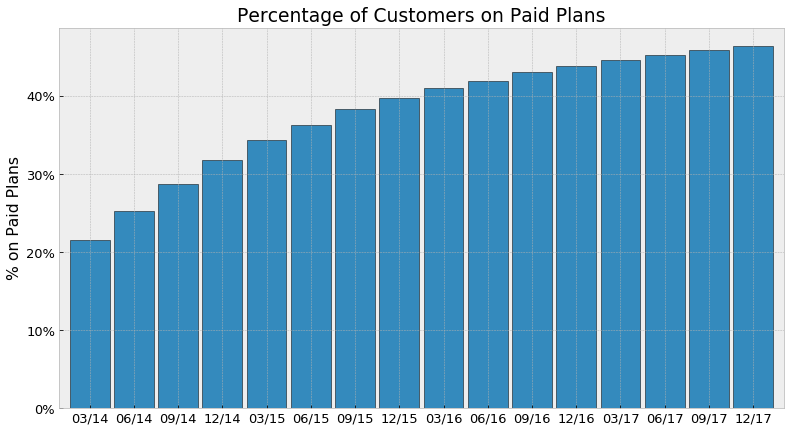

In [17]:
ax = (
    df.assign(
        paid_plan=lambda df: df.subscription_type.apply(lambda x: x > 0)
    )
    .resample('Q')
    .paid_plan.mean()
    .plot.bar(width=.9, ec='black')
)
labels = [pd.to_datetime(t.get_text()).strftime('%m/%y') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=0)
ax.set(title='Percentage of Customers on Paid Plans', ylabel='% on Paid Plans', xlabel='')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))

Might need to clean up those x-axis labels a little more, but we definitely see that more of our customers are converting to paid plans over time, but the rate of conversion seems to be slowing.

Let's now explore what the customers on paid plans look like:

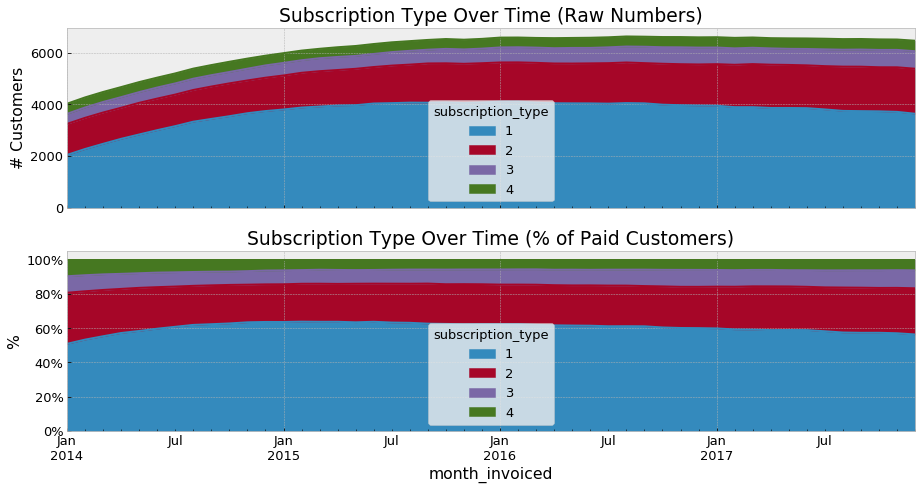

In [18]:
monthly_paid_plans = (
    df.query('subscription_type > 0')
    .groupby('subscription_type')
    .resample('M')
    .size().T
)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

monthly_paid_plans.plot.area(ax=ax1)
ax1.set(title='Subscription Type Over Time (Raw Numbers)', ylabel='# Customers')
monthly_paid_plans.apply(lambda row: row / row.sum(), axis=1).plot.area(ax=ax2)
ax2.set(title='Subscription Type Over Time (% of Paid Customers)', ylabel='%')
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
fig.tight_layout()

Takeaways:

- Not only is our % of paid customers going up over time, it looks like the raw number of paid customers is going up over time as well. This must mean that we aren't getting that many new free-tier sign ups over time.
- It looks like the percentage of customers on tiers 3 and 4 is relatively stable, and there's just a little fluctuation in tiers 1 and 2.

Let's visualize subscription type as % of revenue.

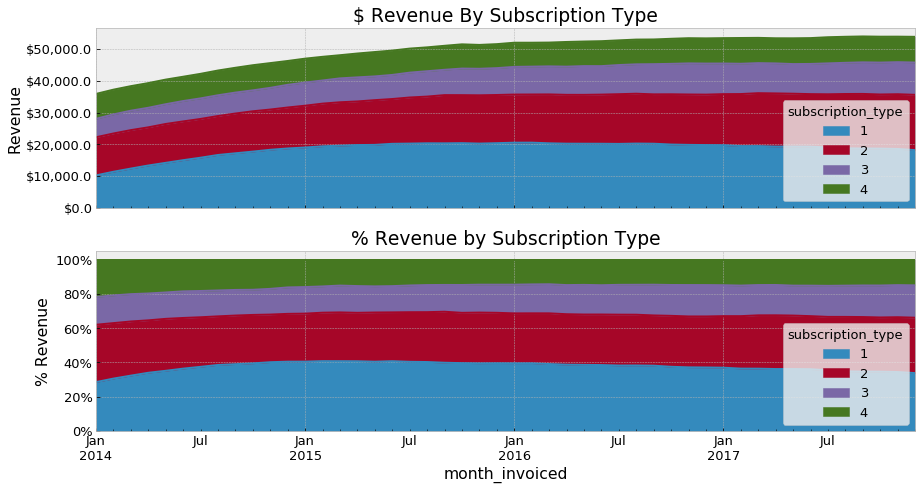

In [19]:
monthly_revenue = (
    df.query('subscription_type > 0') # filter out free plans
    .groupby('subscription_type')
    .resample('M')
    .amount.sum()
    .unstack(0)
)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

monthly_revenue.plot.area(ax=ax1)
ax1.set(title='$ Revenue By Subscription Type', ylabel='Revenue')
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))
monthly_revenue.apply(lambda row: row / row.sum(), axis=1).plot.area(ax=ax2)
ax2.set(title='% Revenue by Subscription Type', ylabel='% Revenue')
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
fig.tight_layout()

[Text(0, 0.5, 'Revenue'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Yearly $ Revenue By Subscription Type')]

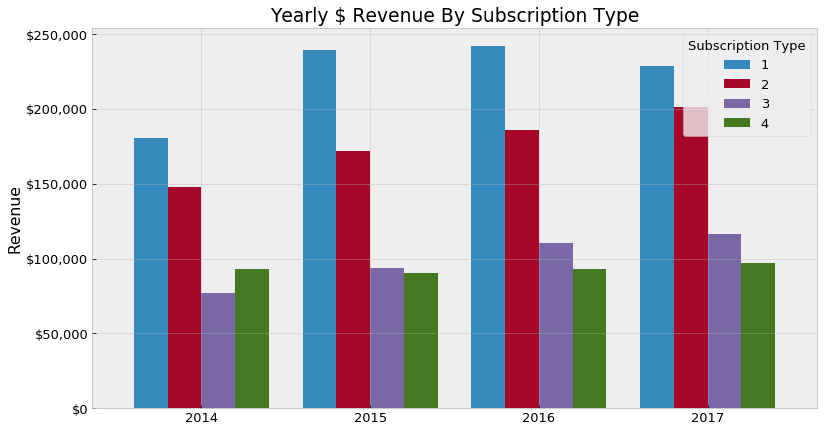

In [20]:
ax = (
    monthly_revenue.resample('Y')
    .sum()
    .plot.bar(width=.8)
)
ax.legend(loc='upper right', title='Subscription Type')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
labels = [pd.to_datetime(t.get_text()).strftime('%Y') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=0)
ax.set(ylabel='Revenue', title='Yearly $ Revenue By Subscription Type', xlabel='')

[Text(0, 0.5, 'Revenue'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Yearly % Revenue By Subscription Type')]

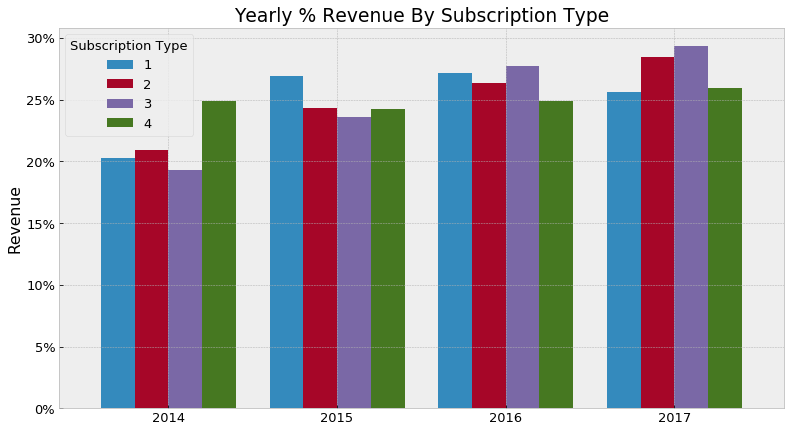

In [21]:
ax = (
    monthly_revenue.resample('Y')
    .sum()
    .apply(lambda row: row / row.sum())
    .plot.bar(width=.8)
)
ax.legend(loc='upper left', title='Subscription Type')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
labels = [pd.to_datetime(t.get_text()).strftime('%Y') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=0)
ax.set(ylabel='Revenue', title='Yearly % Revenue By Subscription Type', xlabel='')

## Conclusion

Working hypothesis: Revenue has flattened out over time because we aren't acquiring enough new customers.

Even though we are seeing the number of paid customers increase over time, the total number of subscriptions is dropping. We need to get more folks to sign up for subscriptions, even on the free tier in order to increase revenue.

Further avenues of exploration:

- calculate churn rate (how many customers do we lose month over month)
- calculate conversion rate (how many new customers do we have each month)
- calculate upgrade rate (how many customers upgrade their plan each month)
- calculate free-paid conversion rate (how many customers on a free plan switch to a paid plan each month)